In [14]:
from math import asin, cos, radians, sin, sqrt
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from osgeo import gdal, ogr, osr
from shapely import ops
from shapely.geometry import LineString, Point, Polygon
from skan import Skeleton, draw, summarize
from skan.csr import skeleton_to_csgraph
from skimage import morphology
from sklearn.cluster import KMeans
import rasterio
import rasterio.crs
import rasterio.warp
from skan import Skeleton, summarize
from skimage import morphology

In [15]:
# 1. 文件路径
input_raster = 'C:/Users/xianyu/GraduationProject/tobacco_plant_count/data/input/pred/061301_full_dilated.tif'
input_vector = 'C:/Users/xianyu/GraduationProject/tobacco_plant_count/data/temp/061301_pred.shp'

In [17]:
# 3. 矢量筛选，只保留短边合适的多边形用于统计面积

def polygon_filter(geom):
    coords = geom.geometry.minimum_rotated_rectangle.exterior.coords
    p1 = Point(coords[0])
    p2 = Point(coords[1])
    p3 = Point(coords[2])
    edge1 = p1.distance(p2)
    edge2 = p2.distance(p3)
    min_edge = min(edge1, edge2)
    return 0.6 < min_edge < 1.0


gdf = gpd.read_file(input_vector)
gdf = gdf.loc[gdf.apply(polygon_filter, axis=1)]
# gdf.loc[:, 'geometry'] = gdf['geometry'].apply(lambda x: Polygon(x.exterior)) #去掉内环
# gdf = gdf.simplify(1e-6)# 简化
# gdf.to_file(output_vector_filtered) # 保存筛选后的矢量
gdf = gdf['geometry']
len(gdf)

73863

In [4]:
def side_of_line(point, line):
    u = np.array(line.coords[1]) - np.array(line.coords[0])
    v = np.array(point.coords[0]) - np.array(line.coords[0])
    # True=left, False=right
    return u[0] * v[1] - u[1] * v[0] > 0


def cut_polygon(geom, interval):
    """
    Cut OBB rectangle into grids
    """
    obb = geom.minimum_rotated_rectangle.exterior.coords
    p1, p2, p3, p4 = Point(obb[0]), Point(obb[1]), Point(obb[2]), Point(obb[3])
    dist1, dist2 = p1.distance(p2), p2.distance(p3)

    if dist1 > dist2:
        long_edge_1 = LineString([p1, p2])
        long_edge_2 = LineString([p4, p3])
    else:
        long_edge_1 = LineString([p2, p3])
        long_edge_2 = LineString([p1, p4])
    # p1 will always on rhe left side

    distances = []
    num = 100
    for i in range(1, num):
        pointA = long_edge_1.interpolate(i / num, normalized=True)
        pointB = long_edge_2.interpolate(i / num, normalized=True)
        curr_line = LineString([pointA, pointB])
        intersect_line = geom.intersection(curr_line)
        if intersect_line.geom_type == 'LineString':
            distances.append(intersect_line.length)
        elif intersect_line.geom_type == 'MultiLineString':
            distances.append(sum(line.length for line in intersect_line.geoms))
    return distances


interval = 0.62  # 1 meter
l = [cut_polygon(geom, interval) for geom in gdf]

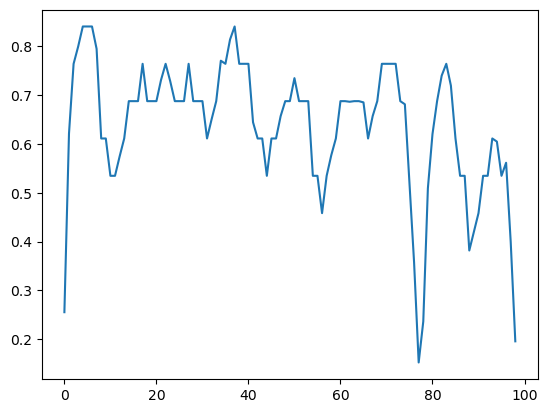

In [9]:
import matplotlib.pyplot as plt
i=2
data = np.array(l[i])
x = np.arange(0, len(data))

plt.plot(x, data, label='0')


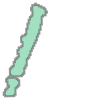

In [10]:
gdf.iloc[i]